# Stack Overflow 2023 Developer Survey

- Dataset: https://insights.stackoverflow.com/survey

In [1]:
# import libraries

import os
import pickle
import click
import mlflow

import numpy as np
import pandas as pd

from zipfile import ZipFile
from joblib import load, dump

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import ast

## Data pre-processing

In [2]:
# Functions

def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)

def load_data(zip_file_path):
    print("Loading data from the zip file...")
    
    # Load data from the zip file
    with ZipFile(zip_file_path) as zip_file:
        df = pd.read_csv(zip_file.open('survey_results_public.csv'))
    
    print("Data loaded successfully.")
    return df

def preprocess_data(df):
    print("Preprocessing data...")
    
    # Drop 'ResponseId' column and remove duplicates
    df = df.drop(['ResponseId'], axis=1).drop_duplicates()
    
    # Set the target variable
    target = "ConvertedCompYearly"
    
    print("Filtering outliers based on the target label...")
    # Filter outliers by selecting records with target label more than 1k USD/year
    df = df[df[target] > 1000]

    # Further exclude 2% of smallest and 2% of highest salaries
    P = np.percentile(df[target], [2, 98])
    df = df[(df[target] > P[0]) & (df[target] < P[1])]
    
    print("Converting YearsCode, YearsCodePro, and WorkExp to integers...")
    # Convert YearsCode, YearsCodePro, and WorkExp to integers
    def clean_years(x):
        if x == 'Less than 1 year':
            return 0
        elif x == 'More than 50 years':
            return 51
        else:
            return x

    df['YearsCode'] = df['YearsCode'].apply(clean_years).fillna(-1).astype(int)
    df['YearsCodePro'] = df['YearsCodePro'].apply(clean_years).fillna(-1).astype(int)
    df['WorkExp'] = df['WorkExp'].fillna(-1).astype(int)
    
    # Fill NaN values with 'none'
    df = df.fillna('none')
    
    print("Dropping unused columns...")
    # Drop unused columns
    cols2drop = ['Q120', 'MainBranch', 'CodingActivities', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 
             'Knowledge_8', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Currency', 'CompTotal', 'LanguageWantToWorkWith', 
            'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 'MiscTechWantToWorkWith', 'ToolsTechWantToWorkWith', 
             'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use', 'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncWantToWorkWith', 'AISearchWantToWorkWith', 
             'AIDevWantToWorkWith', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'SOAI', 'AISelect', 'AISent', 'AIAcc', 'AIBen', 
             'AIToolInterested in Using', 'AIToolCurrently Using', 'AIToolNot interested in Using', 'AINextVery different', 'AINextNeither different nor similar', 
             'AINextSomewhat similar', 'AINextVery similar', 'AINextSomewhat different', 'SurveyLength', 'SurveyEase', 'TimeSearching', 'TimeAnswering']
    df = df.drop(cols2drop, axis=1)
    
    print("Data preprocessing completed successfully.")
    return df

def ref_data(df):
    print("Creating monitoring reference files...")
    # For monitoring reference only
    train_data = df[:35000]
    val_data = df[35000:]

    print("monitoring reference files created...")
    return train_data, val_data

def prepare_data(df):
    # Prepare data for modeling
    print("Preparing data for modeling...")
    target = "ConvertedCompYearly"
    y = df[target].values.reshape(-1,)
    X = df.drop([target], axis=1)
    categorical = df.select_dtypes(include=['object']).columns
    categorical_idx = [list(X.columns).index(c) for c in categorical]
    numerical = ["YearsCode", "YearsCodePro", "WorkExp"]

    print("Data prepared for modeling...")
    return X, y, categorical, categorical_idx, numerical

def train_test_split_data(X, y):
    # Train-test split
    print("Creating Train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    print("Train-test split completed.")
    return X_train, X_test, y_train, y_test


In [3]:
# Usage
zip_file_path = '../data/raw/stack-overflow-developer-survey-2023.zip'
df = load_data(zip_file_path)
df = preprocess_data(df)

# Line separator
print("=" * 50)

train_data, val_data = ref_data(df)
print("train_data shape:", train_data.shape)
print("val_data shape:", val_data.shape)

train_data.to_csv('../data/processed/sf_train_reference.csv')
val_data.to_csv('../data/processed/sf_val_reference.csv')

# Line separator
print("=" * 50)

X, y, categorical, categorical_idx, numerical = prepare_data(df)

# Line separator
print("=" * 50)

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Loading data from the zip file...
Data loaded successfully.
Preprocessing data...
Filtering outliers based on the target label...
Converting YearsCode, YearsCodePro, and WorkExp to integers...
Dropping unused columns...
Data preprocessing completed successfully.
Creating monitoring reference files...
monitoring reference files created...
train_data shape: (35000, 30)
val_data shape: (10430, 30)
Preparing data for modeling...
Data prepared for modeling...
Creating Train-test split...
Train-test split completed.
X_train shape: (31801, 29)
X_test shape: (13629, 29)
y_train shape: (31801,)
y_test shape: (13629,)


In [4]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("catboost-stack-overflow-train")

<Experiment: artifact_location='gs://rh-mlflow-cb-stack-overflow/1', creation_time=1690306440261, experiment_id='1', last_update_time=1690306440261, lifecycle_stage='active', name='catboost-stack-overflow-train', tags={}>

In [5]:
# Check gcs bucket connectivity

from google.cloud import storage

# Initialize the GCS client
client = storage.Client()

# Replace 'your-bucket-name' with the actual name of your bucket
bucket = client.bucket('rh-mlflow-cb-stack-overflow')

# List files in the bucket (for example)
for blob in bucket.list_blobs():
    print(blob.name)


1/3252a3f46f3149eab3197603e1ca3a02/artifacts/model/sf_catboost.bin
1/3252a3f46f3149eab3197603e1ca3a02/artifacts/model/sf_catboost_model
1/3fb781cd5eb741f3a173bba1f9ff4688/artifacts/model/sf_catboost.bin
1/3fb781cd5eb741f3a173bba1f9ff4688/artifacts/model/sf_catboost_model
1/ab87803f71eb4811a29eccf5798f2e7b/artifacts/model/sf_catboost.bin
1/ab87803f71eb4811a29eccf5798f2e7b/artifacts/model/sf_catboost_model
1/dfb237606880487392093a7bc899c83b/artifacts/model/sf_catboost.bin
1/dfb237606880487392093a7bc899c83b/artifacts/model/sf_catboost_model


## Model

In [6]:
# Model

def train_and_evaluate_model(X_train, y_train, X_test, y_test, categorical_idx):
    # Initialize Pool
    train_pool = Pool(X_train, y_train, cat_features=categorical_idx)
    test_pool = Pool(X_test, y_test, cat_features=categorical_idx)

    params = {
        'iterations': 1000,
        'depth': 5,
        'verbose': 0,
        'learning_rate': 0.01,
        'l2_leaf_reg': 15,
        'loss_function': 'RMSE',
        'random_seed': 14
    }

    print("Starting mlfow run...")

    # Start an MLflow run
    mlflow.start_run()

    print("Logging mlfow params...")

    # Log hyperparameters
    mlflow.log_params(params)

    print("Training model...")

    # Model training
    model = CatBoostRegressor(**params)

    # Train the model
    model.fit(train_pool, plot=True)


    print("Evaluating model...")
    # Make the prediction using the resulting model
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)

    # Compute RMSE scores for the model predictions
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    print(f"RMSE score for train: {round(rmse_train, 2)} USD/year, and for test: {round(rmse_test, 2)} USD/year")

    # Baseline scores (assumption - same prediction for all data samples)
    rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train), squared=False)
    rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)] * len(y_test), squared=False)
    print(f"RMSE baseline score for train: {round(rmse_bs_train, 2)} USD/year, and for test: {round(rmse_bs_test, 2)} USD/year")

    print("Logging mlfow metrics...")

    # Log metrics
    mlflow.log_metric("rmse_train", rmse_train)
    mlflow.log_metric("rmse_test", rmse_test)
    mlflow.log_metric("rmse_bs_train", rmse_bs_train)
    mlflow.log_metric("rmse_bs_test", rmse_bs_test)

    # Save the model in catboost cbm format
    model.save_model(fname='../model/sf_catboost_model',
           format="cbm",
           export_parameters=None,
           pool=None)
    
    # Pickle model in binary format
    with open('../model/sf_catboost.bin', 'wb') as f_out:
        pickle.dump(model, f_out)

    print("Logging mlfow artifacts...")

    # Log model artifact
    mlflow.log_artifact(local_path='../model/', artifact_path=None)

    print("Ending mlfow run...")

    # End the run
    mlflow.end_run()

    return model


In [7]:
mlflow.end_run()

In [8]:
# usage

model = train_and_evaluate_model(X_train, y_train, X_test, y_test, categorical_idx)

Starting mlfow run...
Logging mlfow params...
Training model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Evaluating model...
RMSE score for train: 33903.51 USD/year, and for test: 35347.33 USD/year
RMSE baseline score for train: 59193.86 USD/year, and for test: 59119.09 USD/year
Logging mlfow metrics...
Logging mlfow artifacts...
Ending mlfow run...


### Explanations with SHAP

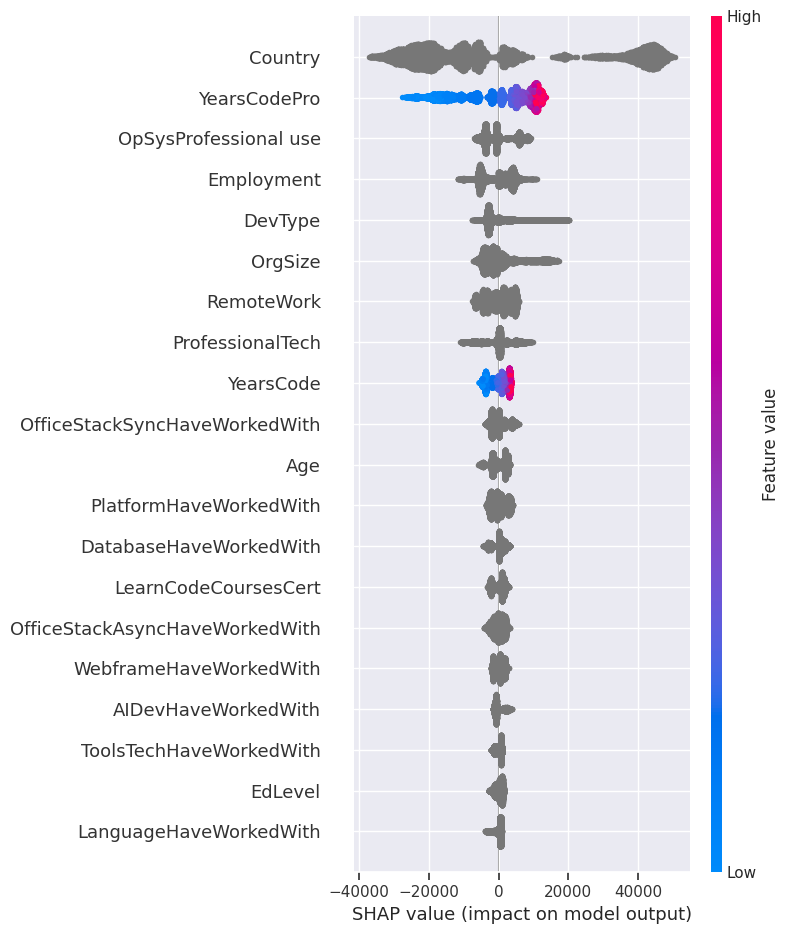

In [9]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [10]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(expected_values,1)} USD/year")
print(f"Average actual salary is {round(np.mean(y_test),1)} USD/year")

Average predicted salary is 89297.3 USD/year
Average actual salary is 89308.6 USD/year


In [11]:
# # save model
# model.save_model(fname='../model/sf_catboost_model',
#            format="cbm",
#            export_parameters=None,
#            pool=None)


### Dump model

In [12]:
# with open('../model/sf_catboost.bin', 'wb') as f_out:
#     dump(model, f_out)

### Load and use saved model

In [13]:
# load model
model_l = CatBoostRegressor()
model_loaded = model_l.load_model(fname='../model/sf_catboost_model')

In [14]:
# predict using loaded model
y_train_pred = model_loaded.predict(X_train)
y_test_pred = model_loaded.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} USD/year, and for test {round(rmse_test,2)} USD/year")

RMSE score for train 33903.51 USD/year, and for test 35347.33 USD/year


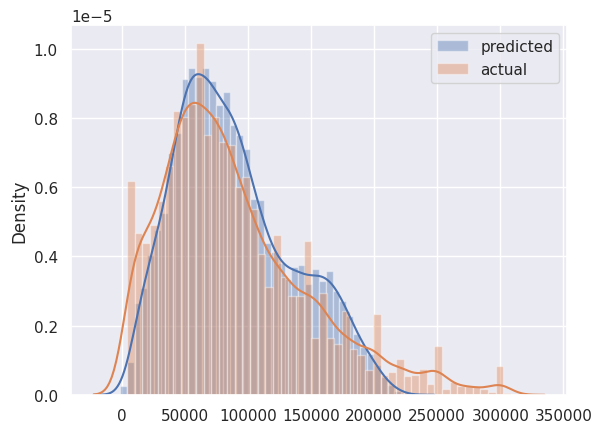

In [15]:
# visualize
sns.distplot(y_test_pred, label='predicted')
sns.distplot(y_test, label='actual')
plt.legend()

In [16]:
# Load dumped model and test
model_path = '../model/sf_catboost.bin'

# Load the model
model_2 = load(model_path)

In [17]:
# predict using loaded model
y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} USD/year, and for test {round(rmse_test,2)} USD/year")

RMSE score for train 33903.51 USD/year, and for test 35347.33 USD/year


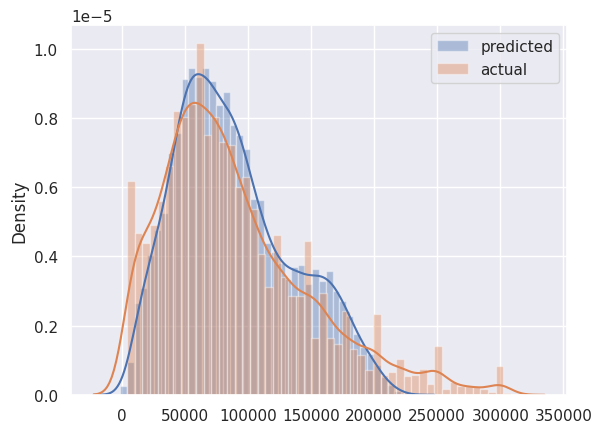

In [18]:
# visualize
sns.distplot(y_test_pred, label='predicted')
sns.distplot(y_test, label='actual')
plt.legend()